In [ ]:
# default_exp connectomes

Module connectomes
---

Pipeline making use of `postprocessing` nodes to generate a connectivity matrix and distance matrix.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti
import os
import bids
bids.config.set_option('extension_initial_dot', True)

from pathlib import Path
from nipype.pipeline import Node, Workflow

import pipetography.nodes as nodes

In [ ]:
#export

class connectome:
    """
    Create a pipeline that produces connectomes based on input atlases and streamlines, the pipeline will create sub-graphs based on inputs BIDS directory subject & session combinations.
    
    Inputs:
         - BIDS_dir (str): base BIDS directory path
         - atlas_list (List of strings): names of atlases: aal, brainnectome, desikan-killiany, default is set to brainnectome for now.
    """
    
    def __init__(self, BIDS_dir, atlas_list, skip_tuples=[()]):
        """
        Initialize workflow nodes
        """
        self.bids_dir = BIDS_dir
        self.atlas_list = atlas_list
        self.skip_combos = skip_tuples
        self.subject_template = {
            'tck': os.path.join(self.bids_dir, 'derivatives', 'streamlines','sub-{subject_id}', 'ses-{session_id}', 'sub-{subject_id}_ses-{session_id}_gmwmi2wm.tck'),
            'brain': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'dwi_space-acpc_res-1mm_seg-brain.nii.gz'),
            'dwi_mif': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'dwi_space-acpc_res-1mm.mif'),
            'T1A': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'T1w_space-acpc.nii.gz'),
            'mask': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'dwi_space-acpc_res-1mm_seg-brain_mask.nii.gz'),
            'mrtrix5tt': os.path.join(self.bids_dir, 'derivatives', 'pipetography', 'sub-{subject_id}', 'ses-{session_id}', 'preprocessed', 'T1w_space-acpc_seg-5tt.mif')
        }
        
        
    def create_nodes(self):
        """
        Create postprocessing nodes, and make output path substitutions so outputs are BIDS compliant.
        """
        self.PostProcNodes = nodes.PostProcNodes(BIDS_dir=self.bids_dir, subj_template = self.subject_template, skip_tuples = self.skip_combos)
        self.PostProcNodes.linear_reg.iterables = [('moving_image', self.atlas_list)]
        self.workflow = None
        
        
    def connect_nodes(self, wf_name="connectomes"):
        """
        Connect postprocessing nodes into workflow
        """
        self.workflow = Workflow(name=wf_name, base_dir=os.path.join(Path(self.bids_dir).parent, 'derivatives'))
        self.workflow.connect(
            [
                (self.PostProcNodes.subject_source, self.PostProcNodes.select_files, [('subject_id', 'subject_id'),
                                                                                      ('session_id', 'session_id')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.linear_reg, [('brain', 'fixed_image')]),
                (self.PostProcNodes.linear_reg, self.PostProcNodes.nonlinear_reg, [('warped_image', 'moving_image')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.nonlinear_reg, [('brain', 'fixed_image')]),
                (self.PostProcNodes.nonlinear_reg, self.PostProcNodes.round_atlas, [('warped_image', 'in_file')]),
                (self.PostProcNodes.round_atlas, self.PostProcNodes.connectome, [('out_file', 'in_parc')]),
                (self.PostProcNodes.round_atlas, self.PostProcNodes.distance, [('out_file', 'in_parc')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.response, [('dwi_mif', 'in_file')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.fod, [('dwi_mif', 'in_file')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.fod, [('mask', 'mask_file')]),
                (self.PostProcNodes.response, self.PostProcNodes.fod, [('wm_file', 'wm_txt')]),
                (self.PostProcNodes.response, self.PostProcNodes.fod, [('gm_file', 'gm_txt')]),
                (self.PostProcNodes.response, self.PostProcNodes.fod, [('csf_file', 'csf_txt')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.sift2, [('mrtrix5tt', 'act')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.sift2, [('tck', 'in_file')]),
                (self.PostProcNodes.fod, self.PostProcNodes.sift2, [('wm_odf', 'in_fod')]),
                (self.PostProcNodes.sift2, self.PostProcNodes.connectome, [('out_file', 'in_weights')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.connectome, [('tck', 'in_file')]),
                (self.PostProcNodes.select_files, self.PostProcNodes.distance, [('tck', 'in_file')]),
                (self.PostProcNodes.connectome, self.PostProcNodes.datasink, [('out_file', 'connectomes.@connectome')]),
                (self.PostProcNodes.distance, self.PostProcNodes.datasink, [('out_file', 'connectomes.@distance')])
            ])
        self.workflow.config['execution'] = {
                                            'use_relative_paths':'True',
                                            'hash_method': 'content',
                                            'stop_on_first_crash': 'True',
                                            }
        
    def draw_pipeline(self, graph_type='orig'):
        """
        Visualize workflow
        """
        self.workflow.write_graph(
            graph2use=graph_type, 
            dotfilename = os.path.join(
                self.bids_dir, 'derivatives', 'pipetography', 'graph', 'postprocessing.dot'
            ),
        )
    
    def run_pipeline(self, parallel=None):
        """
        Run nipype workflow
        """
        if type(parallel) == int:
            print("Running workflow with {} parallel processes".format(parallel))
            self.workflow.run('MultiProc', plugin_args = {'n_procs': parallel})
        elif parallel is None:
            print("Parallel processing disabled, running workflow serially")
            self.workflow.run()

In [ ]:
#hide
#test

test_wf = connectome(BIDS_dir='./testing/BIDS_dir', 
                    atlas_list=['./testing/Atlases/DK_Atlas_86_2mm.nii.gz', 
                                 '/testing/Atlases/BN_Atlas_246_1mm.nii.gz'])
test_wf.create_nodes()
test_wf.connect_nodes()
test_wf.draw_pipeline()
# assert drawn workflow is present as png and dot:
assert os.path.exists('./testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.dot')
assert os.path.exists('./testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.png')
# assert output is compliant with BIDS
assert os.path.abspath(test_wf.PostProcNodes.datasink.inputs.base_directory) == os.path.abspath(os.path.join('./testing/BIDS_dir', 'derivatives', 'pipetography'))

Creating layout of data directory, might take a while if there are a lot of subjects
Data sink (output folder) is set to ./testing/BIDS_dir/derivatives/pipetography
201217-12:54:26,656 nipype.workflow INFO:
	 Generated workflow graph: /Users/xxie/lab/pipetography/testing/BIDS_dir/derivatives/pipetography/graph/postprocessing.png (graph2use=orig, simple_form=True).


## Example

Workflow creating a connectivity matrix and a distance adjacency matrix for brainnectome and desikan-killiany atlas.

In [ ]:
#example
post_wf = connectome(BIDS_dir='/Users/xxie/sample_data/dwipreproc/BIDS_output', 
                     atlas_list=['/Users/xxie/Downloads/atlas86.nii', 
                                 '/Users/xxie/lab/Human_Brain_Atlases/brainnectome/BN_Atlas_246_1mm.nii.gz'], 
                     skip_tuples=[('01', '003')])

Take a look at the post-processing workflow:

Creating layout of data directory, might take a while if there are a lot of subjects
Data sink (output folder) is set to /Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography
201217-12:54:29,703 nipype.workflow INFO:
	 Generated workflow graph: /Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography/graph/postprocessing.png (graph2use=flat, simple_form=True).


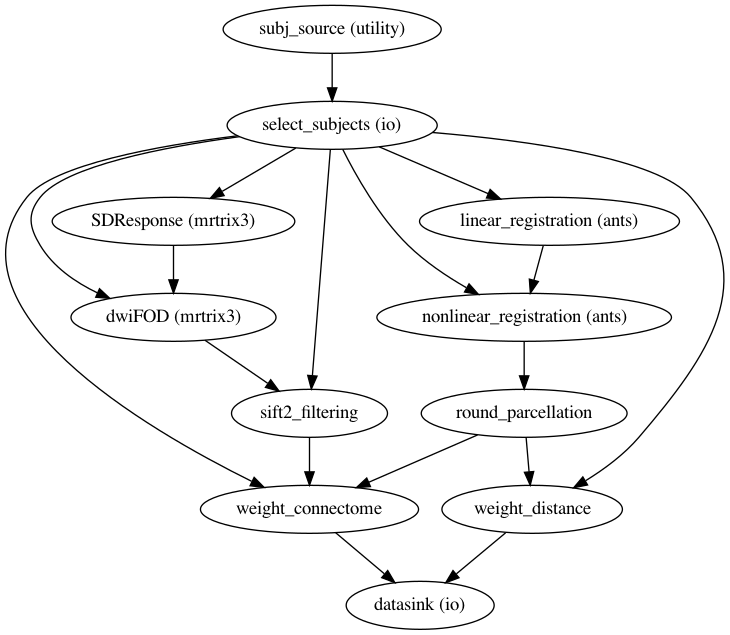

In [ ]:
#example
from IPython.display import Image

post_wf.create_nodes()
post_wf.connect_nodes(wf_name='connectomes')
post_wf.draw_pipeline(graph_type='flat')
Image('/Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography/graph/postprocessing.png')

In [ ]:
#example
post_wf.run_pipeline(parallel=2)

Running workflow with 2 parallel processes
201217-12:54:31,117 nipype.workflow INFO:
	 Workflow connectomes settings: ['check', 'execution', 'logging', 'monitoring']
201217-12:54:31,145 nipype.workflow INFO:
	 Running in parallel.
201217-12:54:31,149 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 28.80/28.80, Free processors: 2/2.
201217-12:54:33,149 nipype.workflow INFO:
	 [Job 0] Completed (connectomes.select_subjects).
201217-12:54:33,152 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 28.80/28.80, Free processors: 2/2.
201217-12:54:33,259 nipype.workflow INFO:
	 [Node] Outdated cache found for "connectomes.linear_registration".
201217-12:54:33,317 nipype.workflow INFO:
	 [Node] Outdated cache found for "connectomes.linear_registration".
201217-12:54:35,149 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 28.40/28.80, Free processors: 0/2.
                     C

View outputs:

In [ ]:
!tree /Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography

/Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography
├── graph
│   ├── postprocessing.dot
│   ├── postprocessing.png
│   ├── postprocessing_detailed.dot
│   ├── postprocessing_detailed.png
│   ├── preprocessing.dot
│   ├── preprocessing.png
│   ├── preprocessing_detailed.dot
│   └── preprocessing_detailed.png
└── sub-01
    └── ses-002
        ├── connectomes
        │   ├── BN_Atlas_246_1mm
        │   │   ├── connectome.csv
        │   │   └── distances.csv
        │   └── atlas86
        │       ├── connectome.csv
        │       └── distances.csv
        └── preprocessed
            ├── T1w_space-acpc.nii.gz
            ├── T1w_space-acpc_seg-5tt.mif
            ├── T1w_space-acpc_seg-gmwmi_mask.nii.gz
            ├── T1w_space-acpc_seg-wm_mask.nii.gz
            ├── dwi_space-acpc_res-1mm.b
            ├── dwi_space-acpc_res-1mm.bvals
            ├── dwi_space-acpc_res-1mm.bvecs
            ├── dwi_space-acpc_res-1mm.json
            ├── dwi_space-acpc_res-1mm.m

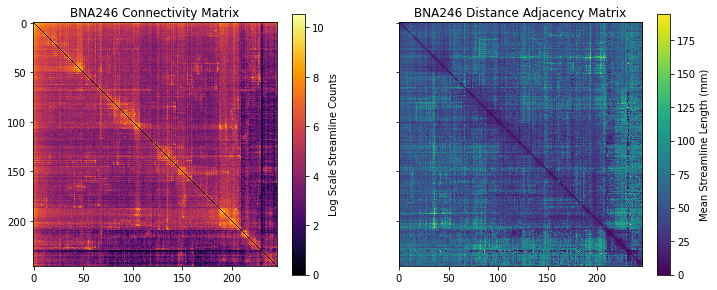

In [ ]:
#usage
#example
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load matrices:
CM = pd.read_csv('/Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography/sub-01/ses-002/connectomes/BN_Atlas_246_1mm/connectome.csv', header = None)
DM = pd.read_csv('/Users/xxie/sample_data/dwipreproc/BIDS_output/derivatives/pipetography/sub-01/ses-002/connectomes/BN_Atlas_246_1mm/distances.csv', header = None)

# Visualize:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (12,12))
# log1p - calculates log(1+x)
cdk=ax1.imshow(np.log1p(CM), cmap = plt.get_cmap('inferno'), interpolation = 'nearest')
ax1.set_title('BNA246 Connectivity Matrix')
cbar=fig.colorbar(cdk, ax=ax1, shrink=0.4)
cbar.set_label('Log Scale Streamline Counts')

ddk=ax2.imshow(DM, interpolation = 'nearest')
ax2.set_title('BNA246 Distance Adjacency Matrix')
dbar=fig.colorbar(ddk, ax=ax2, shrink=0.4)
dbar.set_label('Mean Streamline Length (mm)')